- get the data at: http://www.manythings.org/anki/

In [12]:
from __future__ import print_function, division
from builtins import range, input

import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU,Dense,Embedding,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K


#### Set config

In [2]:
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

input_texts = []   # sentence in original language
target_texts = []  # sentence in target language
target_texts_inputs = []  # sentence in target language offset by 1

#### Load the data

- only keep limit number of samples (faster in training)
- target input (decoder input) 加入 'sos', output 加入 'eos' 

In [3]:
t = 0
for line in open('data/translation/spa.txt',encoding = 'utf8'):
    t +=1
    if t >NUM_SAMPLES:
        break
    ## input and target are seperated by tab
    if '\t' not in line:
        continue
        
    ## split up the input and translation
    input_text, translation = line.split('\t')
    
    ## make the target input and output
    ## recall we'll be using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> '+translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print("num_samples:", len(input_texts))
    
    
    

num_samples: 10000


#### Input preprocessing

- Tokenize
- word index mapping
- determine max length

- don't filter out special characters in output (to keep sos, eos)

In [4]:
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' %len(word2idx_inputs))

max_len_input = max(len(s) for s in input_sequences)

# tokenize outputs
# don't filter out special character
# otherwise <sos> and <eos> won't appear

tokenizer_outputs = Tokenizer(num_words = MAX_NUM_WORDS,filters = '')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs)+1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

Found 2367 unique input tokens.
Found 6329 unique output tokens.


#### Pad Sequences

In [5]:
encoder_inputs = pad_sequences(input_sequences,maxlen = max_len_input)
print("encoder_data.shape :",encoder_inputs.shape)
print("encoder_data[0]:",encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs,maxlen = max_len_target,padding = 'post')
print('decoder_data[0]',decoder_inputs[0])
print('decoder_data.shape:',decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen = max_len_target,padding = 'post')



encoder_data.shape : (10000, 5)
encoder_data[0]: [ 0  0  0  0 15]
decoder_data[0] [   2 1490    0    0    0    0    0    0    0]
decoder_data.shape: (10000, 9)


#### prepare embedding matrix

In [6]:

# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding = 'utf8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))



print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

Loading word vectors...
Found 400000 word vectors.
Filling pre-trained embeddings...


#### Create embedding layer

In [7]:
embedding_layer = Embedding(
num_words,EMBEDDING_DIM,weights = [embedding_matrix],
input_length = max_len_input)

#### Create targets

- can't use sparse categorical cross entropy when we have sequences

In [8]:
decoder_targets_one_hot = np.zeros((len(input_texts),
                                   max_len_target,
                                   num_words_output),
dtype = 'float32')

### Assign value

for i, d in enumerate(decoder_targets):
    for t,word in enumerate(d):
        decoder_targets_one_hot[i,t,word] = 1


#### Build the model

In [17]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
x = Dropout(0.5)(x)

encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)


encoder_outputs, h, c = encoder(x)


# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_inputs_x = Dropout(0.5)(decoder_inputs_x)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  #dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)


# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 9)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 100)       236800      input_14[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 9, 256)       1620480     input_15[0][0]                   
__________________________________________________________________________________________________
dropout_5 

In [18]:
r =model.fit([encoder_inputs,decoder_inputs],decoder_targets_one_hot,
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            validation_split = 0.2,
            verbose = 1)


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 14s 2ms/step - loss: 2.6597 - acc: 0.6569 - val_loss: 2.6238 - val_acc: 0.6583
Epoch 2/100
8000/8000 [==============================] - 11s 1ms/step - loss: 2.0492 - acc: 0.7133 - val_loss: 2.4418 - val_acc: 0.6733
Epoch 3/100
8000/8000 [==============================] - 11s 1ms/step - loss: 1.8547 - acc: 0.7296 - val_loss: 2.3380 - val_acc: 0.6888
Epoch 4/100
8000/8000 [==============================] - 11s 1ms/step - loss: 1.7162 - acc: 0.7454 - val_loss: 2.2420 - val_acc: 0.7017
Epoch 5/100
8000/8000 [==============================] - 11s 1ms/step - loss: 1.6023 - acc: 0.7560 - val_loss: 2.1773 - val_acc: 0.7114
Epoch 6/100
8000/8000 [==============================] - 11s 1ms/step - loss: 1.5034 - acc: 0.7659 - val_loss: 2.1134 - val_acc: 0.7178
Epoch 7/100
8000/8000 [==============================] - 11s 1ms/step - loss: 1.4203 - acc: 0.7737 - val_loss: 2.1040 - val_acc: 0.7238


8000/8000 [==============================] - 12s 1ms/step - loss: 0.4831 - acc: 0.9018 - val_loss: 2.3677 - val_acc: 0.7312
Epoch 61/100
8000/8000 [==============================] - 12s 1ms/step - loss: 0.4781 - acc: 0.9032 - val_loss: 2.3833 - val_acc: 0.7299
Epoch 62/100
8000/8000 [==============================] - 12s 1ms/step - loss: 0.4754 - acc: 0.9044 - val_loss: 2.3735 - val_acc: 0.7313
Epoch 63/100
8000/8000 [==============================] - 12s 1ms/step - loss: 0.4711 - acc: 0.9050 - val_loss: 2.4052 - val_acc: 0.7299
Epoch 64/100
8000/8000 [==============================] - 12s 1ms/step - loss: 0.4679 - acc: 0.9061 - val_loss: 2.4028 - val_acc: 0.7303
Epoch 65/100
8000/8000 [==============================] - 12s 1ms/step - loss: 0.4635 - acc: 0.9065 - val_loss: 2.4095 - val_acc: 0.7311
Epoch 66/100
8000/8000 [==============================] - 12s 1ms/step - loss: 0.4607 - acc: 0.9071 - val_loss: 2.3960 - val_acc: 0.7297
Epoch 67/100
8000/8000 [==============================

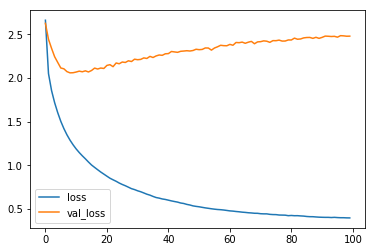

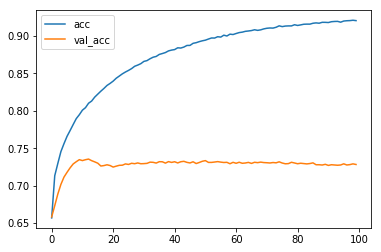

In [19]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

#### Create Predicting Model

- we need to create another model that can take in the RNN state and previous word as input and accept a T=1 sequence.
- The encoder will be stand-alone
- From this we will get our initial decoder hidden state

- decoder_output shape = (number of samples, time steps, number of words)
- Predict words by argmax (highest probability)

- word index start from 1

In [53]:
## encoder_model 輸出encoder states
encoder_model = Model(encoder_inputs_placeholder,encoder_states)

decoder_state_input_h = Input(shape = (LATENT_DIM,))
decoder_state_input_c = Input(shape = (LATENT_DIM,))
decoder_state_inputs = [decoder_state_input_c,decoder_state_input_h]
# decoder_states_inputs = [decoder_state_input_h] # gru
decoder_inputs_single = Input(shape = (1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


# this time, we want to keep the states too, to be output
# by our sampling model

decoder_outputs,h,c = decoder_lstm(decoder_inputs_single_x, initial_state = decoder_state_inputs)

# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru


decoder_states = [h,c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)


decoder_model = Model([decoder_inputs_single]+decoder_state_inputs,
                     [decoder_outputs]+decoder_states)


# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    
    target_seq[0,0] = word2idx_outputs['<sos>']
    
    # if we get this we break
    eos = word2idx_outputs['<eos>']
    
    # Create the translation
    
    output_sentence = []
    
    for _ in range(max_len_target):
        output_tokens,h,c = decoder_model.predict([target_seq]+states_value)
        
      # output_tokens, h = decoder_model.predict(
     #     [target_seq] + states_value
     # ) # gru   
    
    # Get next word

        idx = np.argmax(output_tokens[0,0,:])
        
        ## End sentence of EOS
        if eos == idx:
            break
            
        word = ''
        if idx >0:
            word = idx2word_trans[idx]
            output_sentence.append(word)
            
           # Update the decoder input
    # which is just the word just generated
        target_seq[0,0] = idx
    
        states_value = [h,c]
        # states_value = [h] # gru
        
    return ' '.join(output_sentence)

#### Sampling test (text from input)

In [56]:


i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)

print('-')
print('Input :',input_texts[i])
print('Translation:', translation)



-
Input : His ID was fake.
Translation: su identificación era era ese no le sabía.

